In [ ]:
# Jupyter notebook in Jupytext format

## Initialisation

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [3]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [4]:
folder_name = "ThesisResult4-FeatureSelectionBenchmark"
exp_id = "v1"

if not os.path.exists(f"{path_loader.get_data_path()}data/results/{folder_name}"):
    os.makedirs(f"{path_loader.get_data_path()}data/results/{folder_name}")

file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/"

In [5]:
# Load Proteomics Palbociclib dataset
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(
    loading_code
)

print(f"Proteomic feature data shape: {proteomic_feature_data.shape}")
print(f"Proteomic label data shape: {proteomic_label_data.shape}")

Proteomic feature data shape: (737, 6692)
Proteomic label data shape: (737,)


In [6]:
# Data preparation and alignment
import numpy as np #noqa: E402

# Ensure numeric only
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

print(f"Final aligned dataset shape: {feature_data.shape}")
print(f"Final aligned label shape: {label_data.shape}")

Final aligned dataset shape: (737, 6692)
Final aligned label shape: (737,)


## Functions

In [7]:
from typing import Dict, List, Literal #noqa: E402
import numpy as np #noqa: E402
import pandas as pd #noqa: E402
from scipy.stats import pearsonr, spearmanr #noqa: E402
from sklearn.metrics import r2_score #noqa: E402
from sklearn.dummy import DummyRegressor #noqa: E402
from sklearn.preprocessing import StandardScaler #noqa: E402
from toolkit import FirstQuantileImputer, f_regression_select, get_model_from_string #noqa: E402
from toolkit import (
    mrmr_select_fcq, 
    mutual_information_select, 
) #noqa: E402
import time #noqa: E402

In [8]:
def _drop_correlated_columns(X: pd.DataFrame, threshold: float = 0.95) -> List[str]:
    """Drop highly correlated columns to reduce redundancy"""
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    for col in sorted(upper.columns):
        if col in to_drop:
            continue
        high_corr = upper.index[upper[col] > threshold].tolist()
        to_drop.update(high_corr)
    return [c for c in X.columns if c not in to_drop]

In [9]:
def create_feature_selection_pipeline(
    selection_method: callable, k: int, method_name: str, model_name: str
):
    """Create pipeline for feature selection methods"""

    def pipeline_function(X_train: pd.DataFrame, y_train: pd.Series, rng: int):
        # 1) Sanitize inputs and imputation
        X_train = X_train.replace([np.inf, -np.inf], np.nan)
        y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan)
        mask = ~y_train.isna()
        X_train, y_train = X_train.loc[mask], y_train.loc[mask]

        # 2) Imputation
        imputer = FirstQuantileImputer().fit(X_train)
        Xtr = imputer.transform(X_train, return_df=True).astype(float)
        Xtr = Xtr.fillna(0.0)

        # 3) Correlation filtering (applied to both train and test)
        # Use the working function from your baseline code [1]
        corr_keep_cols = _drop_correlated_columns(Xtr, threshold=0.95)
        Xtr_filtered = Xtr[corr_keep_cols]

        # 4) Feature selection
        k_sel = min(k, Xtr_filtered.shape[1]) if Xtr_filtered.shape[1] > 0 else 0
        if k_sel == 0:
            selected_features, selector_scores = [], np.array([])
            no_features = True
        else:
            selected_features, selector_scores = selection_method(
                Xtr_filtered, y_train, k_sel
            )
            no_features = False

        # 5) Standardization and model training
        if no_features or len(selected_features) == 0:
            model = DummyRegressor(strategy="mean")
            model_type = "DummyRegressor(mean)"
            model_params = {"strategy": "mean"}
            sel_train = Xtr_filtered.iloc[:, :0]
        else:
            sel_train = Xtr_filtered[selected_features]
            scaler = StandardScaler()
            sel_train_scaled = scaler.fit_transform(sel_train)
            sel_train_scaled = pd.DataFrame(
                sel_train_scaled, index=sel_train.index, columns=selected_features
            )

            # Train model
            if model_name == "LinearRegression":
                model = get_model_from_string("LinearRegression")
            elif model_name == "KNeighborsRegressor":
                model = get_model_from_string(
                    "KNeighborsRegressor", n_neighbors=5, weights="distance", p=2
                )
            elif model_name == "SVR":
                model = get_model_from_string("SVR", kernel="linear", C=1.0)
            else:
                raise ValueError(f"Unsupported model: {model_name}")

            model.fit(sel_train_scaled, y_train)
            model_type = model_name
            model_params = (
                model.get_params(deep=False) if hasattr(model, "get_params") else {}
            )

        return {
            "imputer": imputer,
            "corr_keep_cols": corr_keep_cols,
            "selected_features": list(selected_features),
            "selector_scores": np.array(selector_scores),
            "model": model,
            "model_type": model_type,
            "model_params": model_params,
            "scaler": scaler if not no_features else None,
            "no_features": no_features,
            "rng": rng,
        }

    return pipeline_function

In [ ]:
def feature_selection_eval(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    pipeline_components: Dict,
    metric_primary: Literal["r2", "pearson_r", "spearman_r"] = "r2",
) -> Dict:
    """Evaluation function for feature selection benchmarking"""

    # Unpack components following the structure from working baseline code [1]
    imputer = pipeline_components["imputer"]
    corr_keep = set(pipeline_components["corr_keep_cols"])
    selected = list(pipeline_components["selected_features"])
    selector_scores = pipeline_components["selector_scores"]
    model = pipeline_components["model"]
    model_name = pipeline_components["model_type"]
    scaler = pipeline_components.get("scaler", None)
    no_features = pipeline_components.get("no_features", False)

    # Apply identical transforms as training
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    y_test = pd.Series(y_test).replace([np.inf, -np.inf], np.nan)
    mask_y = ~y_test.isna()
    X_test, y_test = X_test.loc[mask_y], y_test.loc[mask_y]

    Xti = imputer.transform(X_test, return_df=True).astype(float).fillna(0.0)

    # Apply same correlation filtering as training [1]
    cols_after_corr = [c for c in Xti.columns if c in corr_keep]
    Xti = Xti[cols_after_corr]

    # Select features
    Xsel = Xti[selected] if len(selected) > 0 else Xti.iloc[:, :0]

    # Standardize if scaler exists (i.e., features were selected)
    if scaler is not None and len(selected) > 0:
        Xsel_scaled = scaler.transform(Xsel)
        Xsel_scaled = pd.DataFrame(Xsel_scaled, index=Xsel.index, columns=selected)
    else:
        Xsel_scaled = Xsel

    # Predict
    if no_features or Xsel.shape[1] == 0:
        y_pred = np.full_like(
            y_test.values, fill_value=float(y_test.mean()), dtype=float
        )
    else:
        y_pred = np.asarray(model.predict(Xsel_scaled), dtype=float)

    # Calculate metrics (following the exact structure from baseline_eval [1])
    mask_fin = np.isfinite(y_test.values) & np.isfinite(y_pred)
    y_t = y_test.values[mask_fin]
    y_p = y_pred[mask_fin]

    if len(y_t) < 2:
        r2 = np.nan
        pearson_r = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
    else:
        r2 = r2_score(y_t, y_p)
        pearson_r, pearson_p = pearsonr(y_t, y_p)
        spearman_rho, spearman_p = spearmanr(y_t, y_p)

    metrics = {
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "pearson_r": float(pearson_r) if np.isfinite(pearson_r) else np.nan,
        "pearson_p": float(pearson_p) if np.isfinite(pearson_p) else np.nan,
        "spearman_rho": float(spearman_rho) if np.isfinite(spearman_rho) else np.nan,
        "spearman_p": float(spearman_p) if np.isfinite(spearman_p) else np.nan,
        "n_test_samples_used": len(y_t),
    }

    # Feature importance
    if not no_features and hasattr(model, "feature_importances_") and len(selected) > 0:
        fi = (np.array(selected), model.feature_importances_)
    elif not no_features and model_name in ("LinearRegression",) and len(selected) > 0:
        coef = getattr(model, "coef_", np.zeros(len(selected)))
        fi = (np.array(selected), np.abs(coef))
    else:
        fi = (np.array(selected), np.zeros(len(selected)))

    primary = metrics.get(metric_primary, metrics["r2"])

    return {
        "feature_importance": fi,
        "feature_importance_from": "model",
        "model_performance": float(primary) if primary is not None else np.nan,
        "metrics": metrics,
        "selected_features": selected,
        "model_name": model_name,
        "selected_scores": selector_scores,
        "k": len(selected),
        "rng": pipeline_components.get("rng", None),
        "y_pred": y_p,
        "y_true_index": y_test.index[mask_fin],
    }

## Execution 

# Isolated MRMR Timing Test

In [19]:
import time
import numpy as np
import pandas as pd
from toolkit import mrmr_select_fcq

# Setup focused test parameters
k_values_to_test = list(range(1, 11))  # k=1 to 10
n_iterations = 5  # Reduce iterations for quick testing

# Prepare data subset for faster testing
feature_subset = feature_data.iloc[:, :5000]  # Use first 500 features for quick testing
print(f"Testing MRMR on subset: {feature_subset.shape}")

Testing MRMR on subset: (737, 5000)


In [20]:
def time_mrmr_selection(X, y, k_values, iterations=5):
    """Time MRMR feature selection for different k values"""
    timing_results = []

    for k in k_values:
        iteration_times = []

        for i in range(iterations):
            start_time = time.time()

            # Pure MRMR selection without any other processing
            selected_features, selector_scores = mrmr_select_fcq(X, y, k)

            end_time = time.time()
            selection_time = end_time - start_time
            iteration_times.append(selection_time)

            print(f"k={k}, iteration {i + 1}: {selection_time:.4f}s")

        # Calculate statistics
        mean_time = np.mean(iteration_times)
        std_time = np.std(iteration_times)

        timing_results.append(
            {
                "k_value": k,
                "mean_time": mean_time,
                "std_time": std_time,
                "min_time": min(iteration_times),
                "max_time": max(iteration_times),
                "n_features_selected": len(selected_features),
            }
        )

        print(f"k={k}: Mean time = {mean_time:.4f}s ± {std_time:.4f}s")

    return pd.DataFrame(timing_results)

In [21]:
# Run MRMR timing test
print("Starting isolated MRMR timing test...")
mrmr_timing_df = time_mrmr_selection(
    feature_subset, label_data, k_values_to_test, n_iterations
)

Starting isolated MRMR timing test...
k=1, iteration 1: 0.2776s
k=1, iteration 2: 0.2390s
k=1, iteration 3: 0.1578s
k=1, iteration 4: 0.2285s
k=1, iteration 5: 0.3153s
k=1: Mean time = 0.2436s ± 0.0527s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=2, iteration 1: 1.6546s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=2, iteration 2: 1.5536s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=2, iteration 3: 1.3682s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=2, iteration 4: 2.3959s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=2, iteration 5: 1.8620s
k=2: Mean time = 1.7669s ± 0.3526s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=3, iteration 1: 3.5446s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=3, iteration 2: 3.9318s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=3, iteration 3: 3.1220s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=3, iteration 4: 3.5007s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


k=3, iteration 5: 2.9986s
k=3: Mean time = 3.4195s ± 0.3318s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=4, iteration 1: 5.0960s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=4, iteration 2: 4.4614s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=4, iteration 3: 4.4941s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=4, iteration 4: 4.6350s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=4, iteration 5: 4.0346s
k=4: Mean time = 4.5442s ± 0.3411s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=5, iteration 1: 5.7117s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=5, iteration 2: 5.9061s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=5, iteration 3: 6.0568s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=5, iteration 4: 9.7824s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=5, iteration 5: 7.3447s
k=5: Mean time = 6.9603s ± 1.5231s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=6, iteration 1: 7.2482s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=6, iteration 2: 7.1585s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=6, iteration 3: 8.9217s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=6, iteration 4: 7.4955s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=6, iteration 5: 7.8435s
k=6: Mean time = 7.7335s ± 0.6398s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=7, iteration 1: 8.3156s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=7, iteration 2: 9.6873s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=7, iteration 3: 8.0719s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=7, iteration 4: 8.4980s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=7, iteration 5: 9.2174s
k=7: Mean time = 8.7580s ± 0.6014s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=8, iteration 2: 11.0480s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=8, iteration 3: 11.3597s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=8, iteration 4: 12.7309s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=8, iteration 5: 14.8483s
k=8: Mean time = 12.4250s ± 1.3475s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=9, iteration 1: 14.4713s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=9, iteration 2: 16.2585s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=9, iteration 3: 15.3283s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=9, iteration 4: 16.9613s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=9, iteration 5: 15.7240s
k=9: Mean time = 15.7487s ± 0.8413s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=10, iteration 1: 15.7024s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=10, iteration 2: 16.3884s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=10, iteration 3: 18.6270s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=10, iteration 4: 13.0197s


c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Github\ode-biomarker-project\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

k=10, iteration 5: 47.7658s
k=10: Mean time = 22.3007s ± 12.8576s


In [22]:
# Display results
print("\nMRMR Timing Results:")
print(mrmr_timing_df.round(4))


MRMR Timing Results:
   k_value  mean_time  std_time  min_time  max_time  n_features_selected
0        1     0.2436    0.0527    0.1578    0.3153                    1
1        2     1.7669    0.3526    1.3682    2.3959                    2
2        3     3.4195    0.3318    2.9986    3.9318                    3
3        4     4.5442    0.3411    4.0346    5.0960                    4
4        5     6.9603    1.5231    5.7117    9.7824                    5
5        6     7.7335    0.6398    7.1585    8.9217                    6
6        7     8.7580    0.6014    8.0719    9.6873                    7
7        8    12.4250    1.3475   11.0480   14.8483                    8
8        9    15.7487    0.8413   14.4713   16.9613                    9
9       10    22.3007   12.8576   13.0197   47.7658                   10


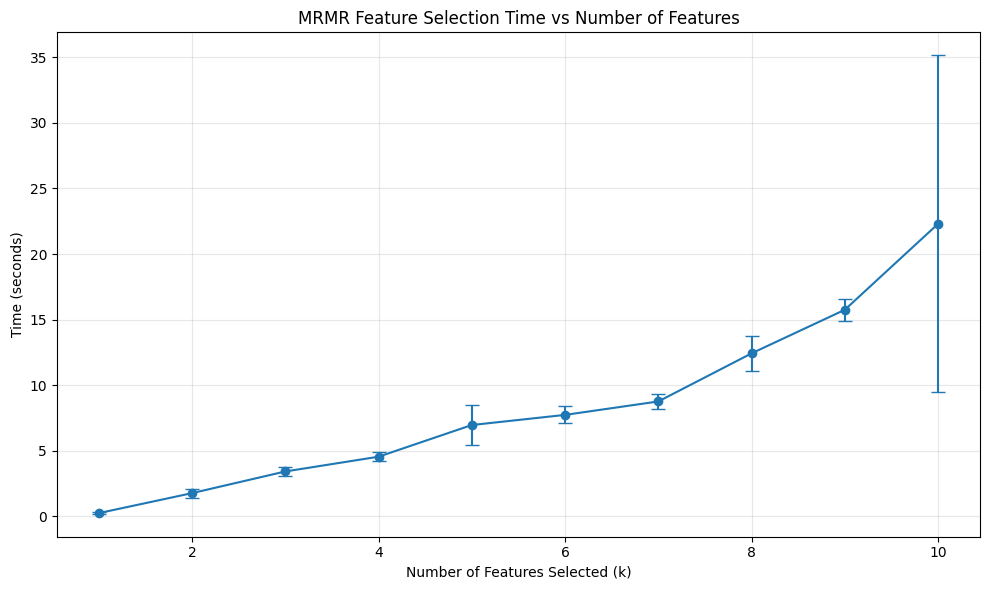

In [24]:
# Plot timing vs k-value
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(
    mrmr_timing_df["k_value"],
    mrmr_timing_df["mean_time"],
    yerr=mrmr_timing_df["std_time"],
    fmt="o-",
    capsize=5,
)
plt.title("MRMR Feature Selection Time vs Number of Features")
plt.xlabel("Number of Features Selected (k)")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Quadratic fit R²: 0.9731
Linear fit R²: 0.9165


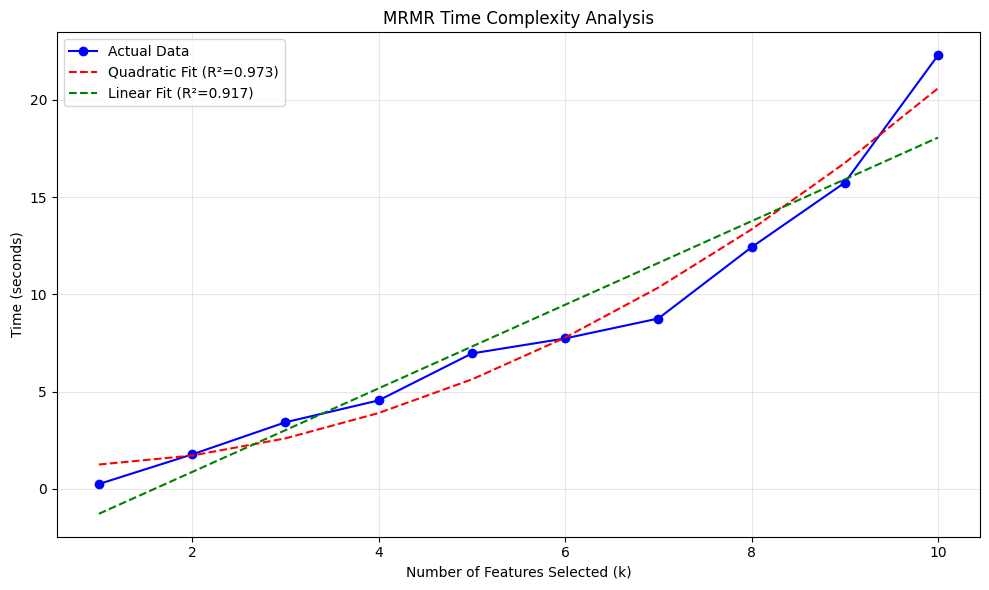

In [25]:
# Analyze time complexity
from scipy.optimize import curve_fit


def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c


def linear_func(x, a, b):
    return a * x + b


# Fit different complexity models
x_data = mrmr_timing_df["k_value"]
y_data = mrmr_timing_df["mean_time"]

try:
    # Quadratic fit (O(n²) complexity)
    popt_quad, _ = curve_fit(quadratic_func, x_data, y_data)
    y_pred_quad = quadratic_func(x_data, *popt_quad)

    # Linear fit (O(n) complexity)
    popt_lin, _ = curve_fit(linear_func, x_data, y_data)
    y_pred_lin = linear_func(x_data, *popt_lin)

    # Calculate R² for both fits
    ss_res_quad = np.sum((y_data - y_pred_quad) ** 2)
    ss_tot_quad = np.sum((y_data - np.mean(y_data)) ** 2)
    r2_quad = 1 - (ss_res_quad / ss_tot_quad)

    ss_res_lin = np.sum((y_data - y_pred_lin) ** 2)
    ss_tot_lin = np.sum((y_data - np.mean(y_data)) ** 2)
    r2_lin = 1 - (ss_res_lin / ss_tot_lin)

    print(f"Quadratic fit R²: {r2_quad:.4f}")
    print(f"Linear fit R²: {r2_lin:.4f}")

    # Plot fits
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, "bo-", label="Actual Data")
    plt.plot(x_data, y_pred_quad, "r--", label=f"Quadratic Fit (R²={r2_quad:.3f})")
    plt.plot(x_data, y_pred_lin, "g--", label=f"Linear Fit (R²={r2_lin:.3f})")
    plt.title("MRMR Time Complexity Analysis")
    plt.xlabel("Number of Features Selected (k)")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Complexity analysis failed: {e}")

In [ ]:
# Save MRMR timing results
mrmr_timing_df.to_csv(f"{file_save_path}mrmr_timing_test_{exp_id}.csv")
print(f"MRMR timing results saved to: {file_save_path}mrmr_timing_test_{exp_id}.csv")

In [11]:
# Setup experiment parameters - using only the three requested methods
feature_set_sizes = [10, 20, 40, 80, 160, 320, 640, 1280]
models = ["KNeighborsRegressor", "LinearRegression", "SVR"]

# Define only the three feature selection methods you requested
feature_selection_methods = {
    "anova_filter": f_regression_select,        # Renamed as ANOVA-filter
    "mrmr": mrmr_select_fcq,                    # MRMR method [2]
    "mutual_info": mutual_information_select    # Mutual Information method [2]
}

print(f"Benchmarking {len(feature_selection_methods)} methods across {len(feature_set_sizes)} feature sizes and {len(models)} models")
print(f"Total conditions: {len(feature_selection_methods) * len(feature_set_sizes) * len(models)}")
print("Methods: ANOVA-filter, MRMR, and Mutual Information")

Benchmarking 3 methods across 8 feature sizes and 3 models
Total conditions: 72
Methods: ANOVA-filter, MRMR, and Mutual Information


In [ ]:
from toolkit import Powerkit
import numpy as np
import time #noqa: F811

# Initialize Powerkit with proteomics data
pk = Powerkit(feature_data, label_data)

# Register all conditions (method × size × model combinations)
rngs = np.random.RandomState(42).randint(0, 100000, size=1)  # 50 repeats for robustness

start_time = time.time()

for method_name, selection_method in feature_selection_methods.items():
    for k in feature_set_sizes:
        for model_name in models:
            # Create condition name using the requested naming convention
            condition = f"{method_name}_k{k}_{model_name}"
            
            # Create pipeline for this method and size
            pipeline_func = create_feature_selection_pipeline(selection_method, k, method_name, model_name)
            
            # Add condition to Powerkit following the structure from previous notebook [1]
            pk.add_condition(
                condition=condition,
                get_importance=True,
                pipeline_function=pipeline_func,
                pipeline_args={},
                eval_function=feature_selection_eval,
                eval_args={"metric_primary": "r2"}
            )

print(f"Registered {len(pk.conditions)} conditions in {time.time() - start_time:.2f} seconds")

In [ ]:
# Run all conditions using Powerkit's parallel processing [1]
print("Starting feature selection benchmark (ANOVA-filter, MRMR, Mutual Information)...")
print(f"Running with {len(rngs)} random seeds and -1 n_jobs for maximum parallelization")

benchmark_start = time.time()
df_benchmark = pk.run_all_conditions(rng_list=rngs, n_jobs=-1, verbose=True)
benchmark_time = time.time() - benchmark_start

print(f"Benchmark completed in {benchmark_time:.2f} seconds")
print(f"Results shape: {df_benchmark.shape}")

In [ ]:
# Extract k value and model name from condition for easier analysis
df_benchmark["k_value"] = df_benchmark["condition"].str.extract(r'k(\d+)').astype(int)
df_benchmark["method"] = df_benchmark["condition"].str.split('_').str[0]
df_benchmark["model_name"] = df_benchmark["condition"].str.split('_').str[2]

print("Condition breakdown:")
print(df_benchmark[["condition", "method", "k_value", "model_name"]].head(10))

In [ ]:
# Save initial results
df_benchmark.to_pickle(f"{file_save_path}feature_selection_benchmark_{exp_id}.pkl")
print(f"Initial results saved to: {file_save_path}feature_selection_benchmark_{exp_id}.pkl")

In [ ]:
# Quick summary of results
print("Benchmark Summary:")
print(f"Total runs: {len(df_benchmark)}")
print(f"Unique conditions: {df_benchmark['condition'].nunique()}")
print(f"Performance range (R²): {df_benchmark['model_performance'].min():.4f} to {df_benchmark['model_performance'].max():.4f}")

# Show performance by method (using the three requested methods)
method_summary = df_benchmark.groupby("method")["model_performance"].agg(["mean", "std", "count"])
print("\nPerformance by method (ANOVA-filter, MRMR, Mutual Information):")
print(method_summary.round(4))

## Results and Visualisation

### Heatmaps